# Algoritmo Fuzzy-C-Means

## Link para o notebook principal

[Notebook principal - main.ipynb](./main.ipynb)

## Tabela de Índices

- [Importando Pacotes e Bibliotecas](#importando-os-pacotes-e-bibliotecas)
- [Importando Datasets Tratados](#importando-os-datasets-tratados)
- [Preparando os Hiper-parâmetros](#preparando-os-hiper-parametros)
- [Usando o Algoritmo](#usando-o-algoritmo-fuzzycmeans)

## Importando os pacotes e bibliotecas

In [1]:
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from utils import parametros
from fcmeans import FCM
import seaborn as sns
import pandas as pd
import numpy as np

## Importando os datasets tratados

In [2]:
df_iris_raw = pd.read_csv("./databases/raw/Iris.csv", sep = ",", index_col = "Id")
df_titanic_processed = pd.read_pickle("./databases/processed/titanic_processado.pkl")
df_coracao_processed = pd.read_pickle("./databases/processed/coracao_processado.pkl")

## Preparando os hiper-parametros

### Separando os **X** e **y** de todos os datasets

In [3]:
min_max_scaler = MinMaxScaler()

X_iris = df_iris_raw.drop(columns = ["Species"]).values
y_iris = df_iris_raw["Species"]

X_titanic = min_max_scaler.fit_transform(df_titanic_processed.drop(columns = ["Survived", "Name"]).values)
y_titanic = df_titanic_processed["Survived"]

X_coracao = min_max_scaler.fit_transform(df_coracao_processed.drop(columns = ["target"]).values)
y_coracao = df_coracao_processed["target"]

### Lendo os hiper-parametros de um arquivo e os salvando em uma classe

In [4]:
hiper_parametros_kmeans = parametros.ParametrosKmeans(path_arquivo_hiperparametros = "./hiperparametros/hiperparametros_kmeans.txt")
hiper_parametros_meanshift = parametros.ParametrosMeanshift(path_arquivo_hiperparametros = "./hiperparametros/hiperparametros_meanshift.txt")
hiper_parametros_cmeans = parametros.ParametrosCmeans(path_arquivo_hiperparametros = "./hiperparametros/hiperparametros_cmeans.txt")
tamanho_teste = 0.6

## Usando o algoritmo FuzzyCMeans

### Imprimindo o resultado dos testes - Dataset Iris

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, train_size = tamanho_teste, random_state = hiper_parametros_kmeans.getSemente_randomica())

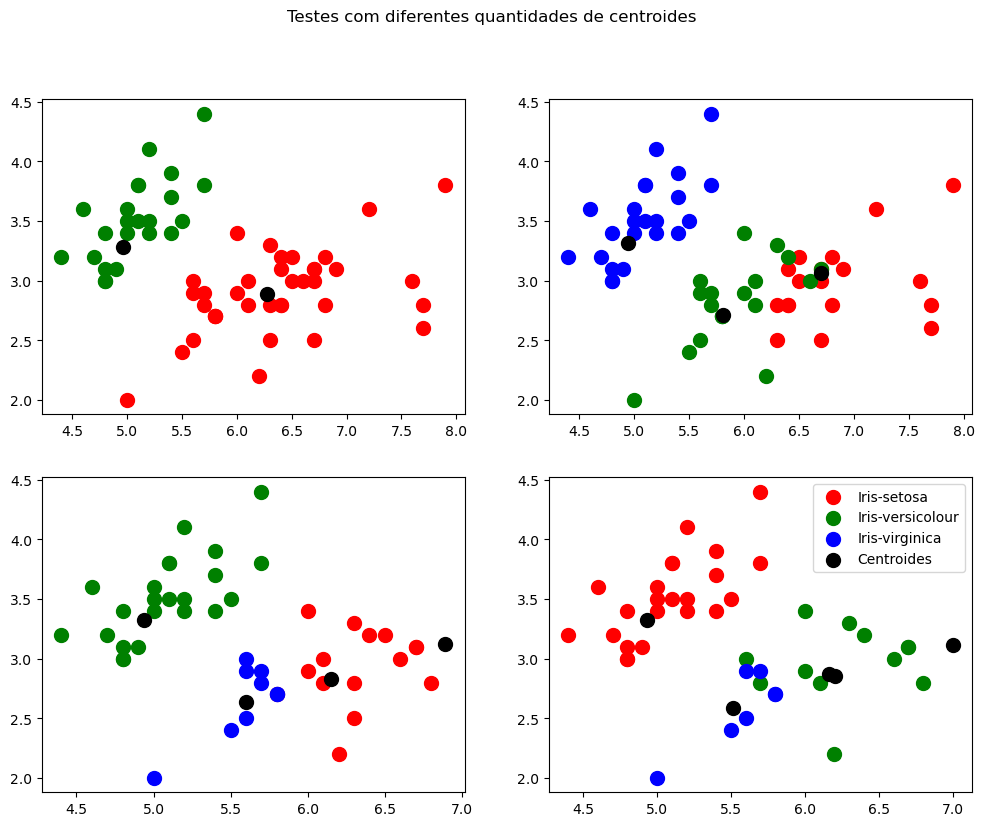

In [6]:
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 9))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = hiper_parametros_cmeans.getParametro_fuzzy(),
                 max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                 distance = hiper_parametros_cmeans.getDistancia(),
                 randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                 error = hiper_parametros_cmeans.getTolerancia(),
                 trained = hiper_parametros_cmeans.getModelo_treinado(),
                 n_jobs = hiper_parametros_cmeans.getNro_threads())

    cmeans.fit(X_train)
    y_cmeans = cmeans.predict(X_test)
    centros = cmeans.centers
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_test[y_cmeans == 0, 0], X_test[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
    eixos[j][k].scatter(X_test[y_cmeans == 1, 0], X_test[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
    eixos[j][k].scatter(X_test[y_cmeans == 2, 0], X_test[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, valor 3 é o que melhor descreve o conjunto dos pontos. Então será escolhido 3 como parâmetro para futuros testes no modelo

### Implementando a clusterização - Dataset Iris

In [7]:
nro_de_clusters = 3

cmeans_iris = FCM(n_clusters = nro_de_clusters,
                  m = hiper_parametros_cmeans.getParametro_fuzzy(),
                  max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                  distance = hiper_parametros_cmeans.getDistancia(),
                  randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                  error = hiper_parametros_cmeans.getTolerancia(),
                  trained = hiper_parametros_cmeans.getModelo_treinado(),
                  n_jobs = hiper_parametros_cmeans.getNro_threads())

cmeans_iris.fit(X_train)
y_cmeans_iris = cmeans_iris.predict(X_test)
centros_iris = cmeans_iris.centers

##### Visualizando os clusters

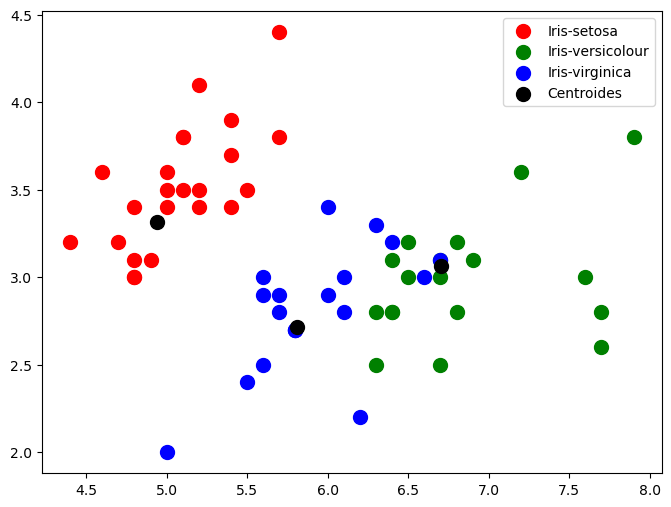

In [8]:
plt.figure(figsize = (8, 6))

### OS PONTOS GERAIS
plt.scatter(X_test[y_cmeans_iris == 0, 0], X_test[y_cmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_test[y_cmeans_iris == 1, 0], X_test[y_cmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_test[y_cmeans_iris == 2, 0], X_test[y_cmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES

plt.scatter(centros_iris[:, 0], centros_iris[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

##### Avaliação do método - Dataset Iris

In [9]:
# POSSIVEIS METRICAS
# ‘cityblock’,
# ‘cosine’,
# ‘euclidean’,
# ‘l1’,
# ‘l2’,
# ‘manhattan’

silhouette = []

for metrica in ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]:
    silhouette.append(silhouette_score(X_train, cmeans_iris.u.argmax(axis = 1), metric = metrica))

davies_bouldin = davies_bouldin_score(X_train, cmeans_iris.u.argmax(axis = 1))
print("SILHOUETTE SCORE: ", silhouette, end = "\n")
print("DAVIS-BOULDIN SCORE: ", davies_bouldin, end = "\n")

SILHOUETTE SCORE:  [0.5355247951405158, 0.4594715306863491, 0.5304368002603884, 0.5355247951405158, 0.5304368002603884, 0.5355247951405158]
DAVIS-BOULDIN SCORE:  0.6661442640428213


### Imprimindo o resultado dos testes - Dataset Titanic

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, train_size = tamanho_teste, random_state = hiper_parametros_kmeans.getSemente_randomica())

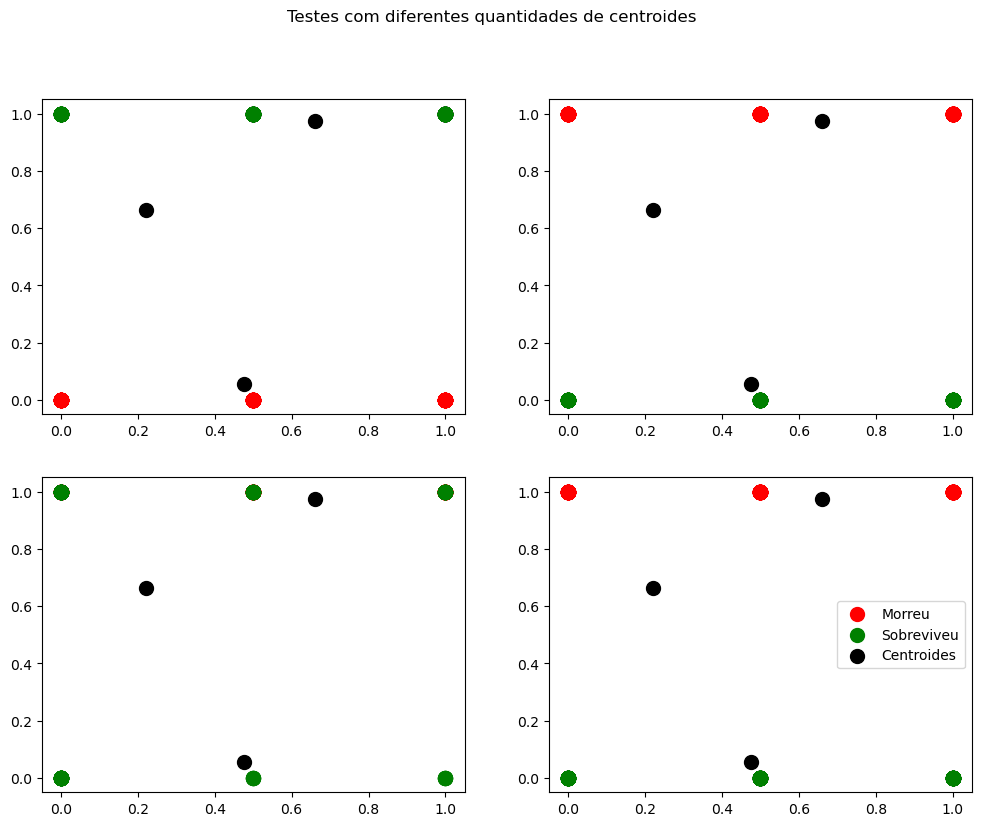

In [11]:
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 9))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = nro_de_clusters,
                 m = hiper_parametros_cmeans.getParametro_fuzzy(),
                 max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                 distance = hiper_parametros_cmeans.getDistancia(),
                 randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                 error = hiper_parametros_cmeans.getTolerancia(),
                 trained = hiper_parametros_cmeans.getModelo_treinado(),
                 n_jobs = hiper_parametros_cmeans.getNro_threads())

    cmeans.fit(X_train)
    y_cmeans = cmeans.predict(X_test)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_test[y_cmeans == 0, 0], X_test[y_cmeans == 0, 1], s = 100, c = "red", label = "Morreu")
    eixos[j][k].scatter(X_test[y_cmeans == 1, 0], X_test[y_cmeans == 1, 1], s = 100, c = "green", label = "Sobreviveu")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, nenhum valor descreve melhor o conjunto dos pontos.
Mas será escolhido 2 como parâmetro para futuros testes no modelo, pois já sabemos que há 2 clusters

### Implementando a clusterização - Dataset Titanic

In [12]:
nro_de_clusters = 2

cmeans_titanic = FCM(n_clusters = nro_de_clusters,
                  m = hiper_parametros_cmeans.getParametro_fuzzy(),
                  max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                  distance = hiper_parametros_cmeans.getDistancia(),
                  randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                  error = hiper_parametros_cmeans.getTolerancia(),
                  trained = hiper_parametros_cmeans.getModelo_treinado(),
                  n_jobs = hiper_parametros_cmeans.getNro_threads())

cmeans_titanic.fit(X_train)
y_cmeans_titanic = cmeans_titanic.predict(X_test)
centros_titanic = cmeans_titanic.centers

##### Visualizando os clusters

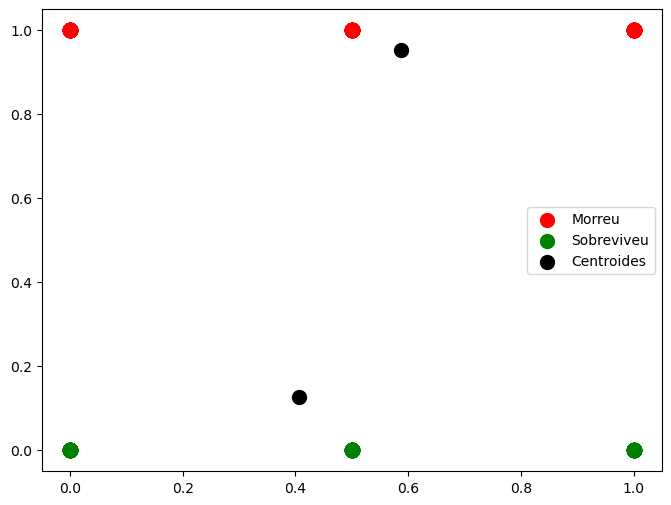

In [13]:
plt.figure(figsize = (8, 6))

### OS PONTOS GERAIS
plt.scatter(X_test[y_cmeans_titanic == 0, 0], X_test[y_cmeans_titanic == 0, 1], s = 100, c = "red", label = "Morreu")
plt.scatter(X_test[y_cmeans_titanic == 1, 0], X_test[y_cmeans_titanic == 1, 1], s = 100, c = "green", label = "Sobreviveu")

### OS CENTROIDES

plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

##### Avaliação do método - Dataset Titanic

In [14]:
# POSSIVEIS METRICAS
# ‘cityblock’,
# ‘cosine’,
# ‘euclidean’,
# ‘l1’,
# ‘l2’,
# ‘manhattan’

silhouette = []

for metrica in ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]:
    silhouette.append(silhouette_score(X_train, cmeans_titanic.u.argmax(axis = 1), metric = metrica))

davies_bouldin = davies_bouldin_score(X_train, cmeans_titanic.u.argmax(axis = 1))
print("SILHOUETTE SCORE: ", silhouette, end = "\n")
print("DAVIS-BOULDIN SCORE: ", davies_bouldin, end = "\n")

SILHOUETTE SCORE:  [0.4814594711445003, 0.5492757625276731, 0.4168255399196876, 0.4814594711445003, 0.4168255399196876, 0.4814594711445003]
DAVIS-BOULDIN SCORE:  1.1398282994213549


### Imprimindo o resultado dos testes - Dataset Coração

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_coracao, y_coracao, train_size = tamanho_teste, random_state = hiper_parametros_kmeans.getSemente_randomica())

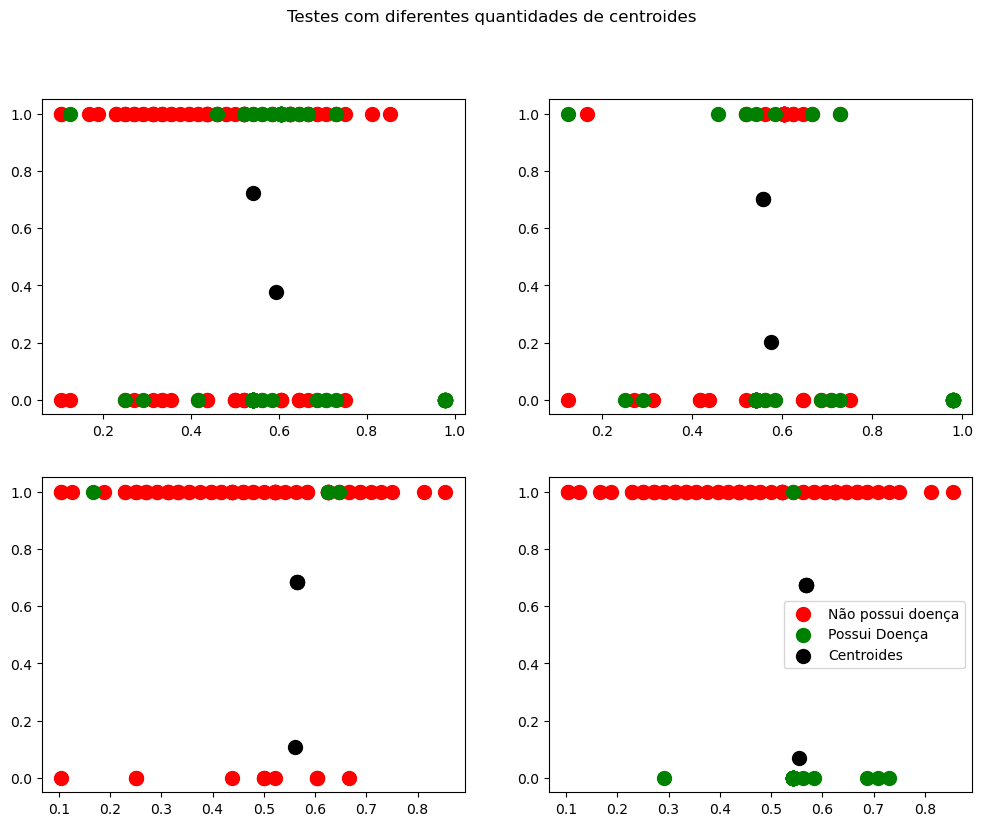

In [16]:
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 9))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = hiper_parametros_cmeans.getParametro_fuzzy(),
                 max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                 distance = hiper_parametros_cmeans.getDistancia(),
                 randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                 error = hiper_parametros_cmeans.getTolerancia(),
                 trained = hiper_parametros_cmeans.getModelo_treinado(),
                 n_jobs = hiper_parametros_cmeans.getNro_threads())

    cmeans.fit(X_train)
    y_cmeans = cmeans.predict(X_test)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_test[y_cmeans == 0, 0], X_test[y_cmeans == 0, 1], s = 100, c = "red", label = "Não possui doença")
    eixos[j][k].scatter(X_test[y_cmeans == 1, 0], X_test[y_cmeans == 1, 1], s = 100, c = "green", label = "Possui Doença")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, nenhum valor descreve melhor o conjunto dos pontos.
Mas será escolhido 2 como parâmetro para futuros testes no modelo, pois já sabemos que há 2 clusters

### Implementando a clusterização - Dataset Doenca do Coracao

In [17]:
nro_de_clusters = 2

cmeans_coracao = FCM(n_clusters = nro_de_clusters,
                     m = hiper_parametros_cmeans.getParametro_fuzzy(),
                     max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                     distance = hiper_parametros_cmeans.getDistancia(),
                     randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                     error = hiper_parametros_cmeans.getTolerancia(),
                     trained = hiper_parametros_cmeans.getModelo_treinado(),
                     n_jobs = hiper_parametros_cmeans.getNro_threads())

cmeans_coracao.fit(X_train)
y_cmeans_coracao = cmeans_coracao.predict(X_test)
centros_coracao = cmeans_coracao.centers

##### Visualizando os clusters

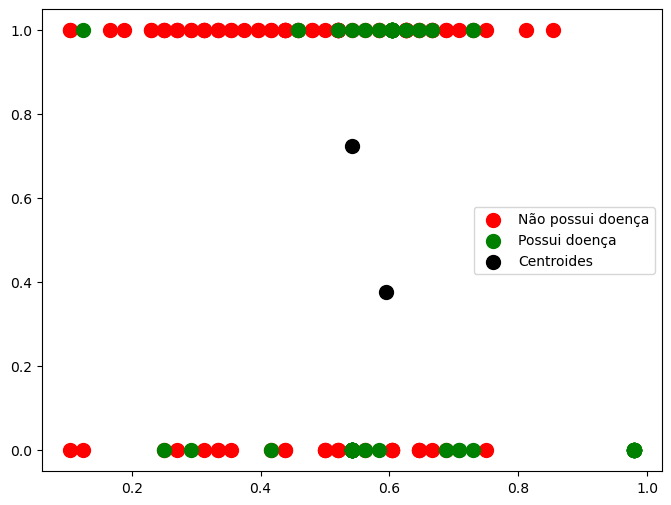

In [18]:
plt.figure(figsize = (8, 6))

### OS PONTOS GERAIS
plt.scatter(X_test[y_cmeans_coracao == 0, 0], X_test[y_cmeans_coracao == 0, 1], s = 100, c = "red", label = "Não possui doença")
plt.scatter(X_test[y_cmeans_coracao == 1, 0], X_test[y_cmeans_coracao == 1, 1], s = 100, c = "green", label = "Possui doença")

### OS CENTROIDES

plt.scatter(centros_coracao[:, 0], centros_coracao[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

##### Avaliação do método - Dataset Coração

In [19]:
# POSSIVEIS METRICAS
# ‘cityblock’,
# ‘cosine’,
# ‘euclidean’,
# ‘l1’,
# ‘l2’,
# ‘manhattan’

silhouette = []

for metrica in ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]:
    silhouette.append(silhouette_score(X_train, cmeans_coracao.u.argmax(axis = 1), metric = metrica))

davies_bouldin = davies_bouldin_score(X_train, cmeans_coracao.u.argmax(axis = 1))
print("SILHOUETTE SCORE: ", silhouette, end = "\n")
print("DAVIS-BOULDIN SCORE: ", davies_bouldin, end = "\n")

SILHOUETTE SCORE:  [0.2569524643701939, 0.3204483058031866, 0.2088048084245043, 0.2569524643701939, 0.2088048084245043, 0.2569524643701939]
DAVIS-BOULDIN SCORE:  1.9517671061809676
